This file contains python code to mimic real setting

It is under the linear setting

Now, I use the same beta from the paper but the PSD as X

In [1]:
import sys
sys.path.append("../../mypkg")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from numbers import Number

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from scipy.io import loadmat
from pprint import pprint
import itertools
from scipy.stats import chi2


In [3]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [4]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from default_paras import def_paras

from hdf_utils.data_gen import gen_simu_psd_dataset
from hdf_utils.fns_sinica import coef_fn, fourier_basis_fn, gen_sini_Xthetas
from hdf_utils.likelihood import obt_lin_tm
from hdf_utils.SIS import SIS_GLIM
from hdf_utils.utils import gen_lam_seq
from hdf_utils.hypo_test import  MS2idxs, obt_test_stat_simple2, obt_test_stat_simple3
from hdf_utils.variable_selection import GIC_fn, GCV_fn
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse, cholesky_inv
from utils.functions import logit_fn
from utils.misc import save_pkl, load_pkl
from splines import obt_bsp_obasis_Rfn, obt_bsp_basis_Rfn_wrapper
from projection import euclidean_proj_l1ball
from optimization.opt import HDFOpt
from penalties.scad_pen import SCAD
from models.linear_model import LinearModel

from joblib import Parallel, delayed

In [5]:
plt.style.use(FIG_ROOT/"base.mplstyle")
torch.set_default_tensor_type(torch.DoubleTensor)

# Params

In [6]:
np.random.seed(0)
paras = edict()



# Others
paras.num_rep = 200 
paras.model_type = "linear"

# candidate sets of tuning parameters, only two 
# lambda: penalty term
# N: num of basis
paras.can_lams = [0.01, 0.1, 0.2, 0.3, 0.4, 0.6, 1, 2, 8]
paras.can_Ns = [4, 6, 8, 10, 12]


# basis 
paras.bsp_params = edict({
            "basis_ord": 4, 
            "is_orth_basis": True, 
            "N": None
        })
if paras.bsp_params.is_orth_basis: 
    obt_bsp = obt_bsp_obasis_Rfn
else:
    obt_bsp = obt_bsp_basis_Rfn_wrapper
    
if paras.model_type.startswith("linear"):
    paras.model_params = edict({
                "norminal_sigma2": 1
                    })
elif paras.model_type.startswith("logi"):
    paras.model_params = edict({})

paras.pen_params= edict({
            "a": 3.7, 
            "lam": None,
                })

if paras.model_type.startswith("linear"):
    paras.opt_params= edict({
               'stop_cv': 0.0005,
               'max_iter': 2000, 
               "one_step_verbose":0,
               'alpha': 0.9,
               'beta': 10,
               'R': 1e5,
               "linear_theta_update": "cholesky_inv",
               "linear_mat": None, 
             })
elif paras.model_type.startswith("logi"):
    paras.opt_params= edict({
               'stop_cv': 0.0005,
               'max_iter': 2000, 
               "one_step_verbose":0,
               'alpha': 0.9,
               'beta': 1.5,
               'R': 1e5,
               'N_eps': 1e-4,
               'N_maxit': 100,
               "is_BFGS": "adaptive", 
             })

paras.SIS_params = edict({
             "SIS_pen": 0.02,  
             "SIS_basis_N": 8,  
             "SIS_basis_ord": None,
             "SIS_ratio": 0.2, 
         })
    

# generating dataset
paras.n = 200 # num of data obs to be genareted
paras.d = 68 # num of ROIs
paras.q = 3 # num of other covariates
paras.npts = 100 # num of pts to evaluate X(s)
paras.freqs = np.linspace(2, 45, paras.npts) # freqs
paras.sigma2 = 1 # variance of the error
# variance used for estimation, note that the value does not affect any results 
# as long as I tune the parameter properly
paras.types_ = ["int", "c", 2]
paras.is_std = False
# True parameters
paras.x = np.linspace(0, 1, paras.npts)
paras.alp_GT = np.array([5, -1, 2])
# fourier basis
cs = [0.0, 0.0, 0.0] # for sinica paper
paras.cs = cs
paras.fourier_basis = fourier_basis_fn(paras.x)[:, :]
paras.fourier_basis_coefs = ([cs[0]*coef_fn(0.2), cs[1]*coef_fn(0.2), cs[2]*coef_fn(0.2)] + 
                             [np.zeros(50)] * (paras.d-3-1) +
                             [coef_fn(0.2)]
                             )
paras.fourier_basis_coefs = np.array(paras.fourier_basis_coefs).T 
paras.beta_GT = paras.fourier_basis @ paras.fourier_basis_coefs * 2
beta_GT_norm = np.linalg.norm(paras.beta_GT, axis=0)
print(beta_GT_norm[beta_GT_norm!=0])


# CV
paras.num_cv_fold = 10


# hypothesis test
#without loss of generality, we assume the idxs in M is the first m betas
paras.sel_idx = np.arange(1, paras.d) # M^c set, 
paras.Cmats = [
    np.eye(paras.d-len(paras.sel_idx)), # m x m I matrix, [beta1, beta2] = [0, 0]
]
paras.hypo_params = edict({
            "svdinv_eps_Q": 1e-7,
            "svdinv_eps_Psi": 1e-7,
            "Cmat": None
        })

# saving path
paras.save_dir = RES_ROOT/"test"
if not paras.save_dir.exists():
    paras.save_dir.mkdir()

[29.74717132]



# Simu


## Check data gen fn

In [8]:
data = gen_simu_psd_dataset(paras.n, paras.d, paras.q, paras.types_, 
                            paras.alp_GT, paras.beta_GT, paras.freqs, 
                 data_type=paras.model_type, data_params={"err_dist": "norm", "sigma2": paras.sigma2, "psd_noise_sd":10}, 
                 seed=0, is_std=paras.is_std, verbose=True, is_gen=False);

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_real/../../mypkg/../mid_results/PSD_d-68_n-500_npts-100_is_std-False/seed_0.pkl


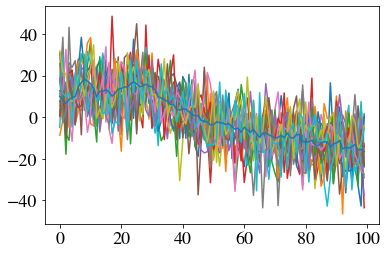

In [9]:
idx = 100
for ix in range(20):
    plt.plot(data.X[idx, ix, :])
plt.plot(data.X[idx, :, :].mean(axis=0))
#plt.plot(data.X[idx, 0, :])
#plt.plot(data.X[idx, 1, :])

## SIS check (just for check)

In [12]:
paras.bsp_params

{'basis_ord': 4, 'is_orth_basis': True, 'N': None}

In [16]:
def _SIS_fn(seed, SIS_ratio, N, SIS_pen, paras):
    torch.set_default_dtype(torch.double)
    np.random.seed(seed)
    torch.manual_seed(seed)
        
    _paras = edict(paras.copy())
    _paras.seed = seed
    _paras.N = N
    _paras.basis_mat = torch.tensor(obt_bsp(_paras.x, _paras.N, _paras.bsp_params.basis_ord)).to(torch.get_default_dtype())
    cur_data = gen_simu_psd_dataset(_paras.n, _paras.d, _paras.q, _paras.types_, 
                            _paras.alp_GT, _paras.beta_GT, _paras.freqs, 
                 data_type=_paras.model_type, data_params={"err_dist": "norm", "sigma2": _paras.sigma2, "psd_noise_sd":10}, 
                 seed=seed, is_std=_paras.is_std, verbose=False, is_gen=False);
    
    keep_idxs, _  = SIS_GLIM(Y=cur_data.Y, X=cur_data.X, Z=cur_data.Z, 
                             basis_mat=_paras.basis_mat, keep_ratio=SIS_ratio, 
                             model_type="linear", SIS_pen=SIS_pen, sel_idx=_paras.sel_idx)
    M_idxs = np.delete(np.arange(_paras.d), _paras.sel_idx)
    _paras.keep_idxs = np.sort(np.concatenate([M_idxs, keep_idxs]))
    return _paras.keep_idxs

In [14]:
num_rep = 200
with Parallel(n_jobs=20) as parallel:
    keep_idxss = parallel(delayed(_SIS_fn)(seed, 0.20, N=8, SIS_pen=0.02, paras=paras) for seed in 
                          tqdm(range(0, num_rep), total=num_rep))


 10%|█████████████▋                                                                                                                           | 20/200 [00:00<00:02, 72.72it/s]R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate



 20%|███████████████████████████▍

Text(0.5, 1.0, '[0.185 0.225 0.165 0.22  0.2   0.17  1.   ]')

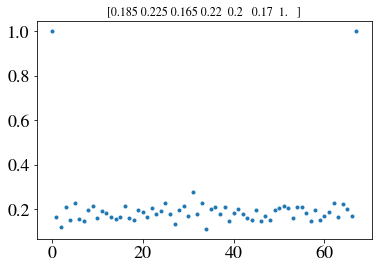

In [17]:
vs, cts = np.unique(np.concatenate(keep_idxss), return_counts=1);
cts = cts[np.argsort(vs)]/len(keep_idxss)
vs = np.sort(vs);
plt.plot(vs, cts, ".")
plt.title(f"{cts[vs > 60]}")

## Simulation

In [7]:
def _run_fn(seed, lam, N, paras, is_save=False, is_cv=False, verbose=2):
    """Now (on Aug 25, 2023), if we keep seed the same, the cur_data is the same. 
       If you want to make any changes, make sure this. 
    """
    torch.set_default_dtype(torch.double)
    np.random.seed(seed)
    torch.manual_seed(seed)
        
    _paras = edict(paras.copy())
    _paras.seed = seed
    _paras.lam = lam
    _paras.N = N
    
    f_name = f"seed_{seed:.0f}-lam_{lam*1000:.0f}-N_{N:.0f}-c1_{_paras.cs[0]*1000:.0f}_fit.pkl"
    
    
    if not (_paras.save_dir/f_name).exists():
        
        cur_data = gen_simu_psd_dataset(_paras.n, _paras.d, _paras.q, _paras.types_, 
                                _paras.alp_GT, _paras.beta_GT, _paras.freqs, 
                     data_type=_paras.model_type, data_params={"err_dist": "norm", "sigma2": _paras.sigma2, "psd_noise_sd":10}, 
                     seed=_paras.seed, is_std=_paras.is_std, verbose=verbose, is_gen=False);
        hdf_fit = HDFOpt(lam=_paras.lam, 
                         sel_idx=_paras.sel_idx, 
                         model_type=_paras.model_type,
                         verbose=verbose, 
                         SIS_ratio=_paras.SIS_params.SIS_ratio, 
                         N=_paras.N,
                         is_std_data=True, 
                         cov_types=None, 
                         inits=None,
                         model_params = _paras.model_params, 
                         SIS_params = _paras.SIS_params, 
                         opt_params = _paras.opt_params,
                         bsp_params = _paras.bsp_params, 
                         pen_params = _paras.pen_params
               );
        hdf_fit.add_data(cur_data.X, cur_data.Y, cur_data.Z)
        opt_res = hdf_fit.fit()
        
        if is_cv:
            hdf_fit.get_cv_est(_paras.num_cv_fold)
        if is_save:
            hdf_fit.save(_paras.save_dir/f_name, hdf_fit, is_force=True)
    else:
        hdf_fit = load_pkl(_paras.save_dir/f_name);
        
    return hdf_fit


### single test

In [8]:
seed = 2
lam = 1.1
N = 8 

res = _run_fn(seed=seed, lam=lam, N=N, paras=paras, is_cv=False, verbose=3)
res.hypo_test(paras.Cmats[0]), res.hypo_test(paras.Cmats[0], is_simpler=True)

2024-01-02 16:50:38,822 - optimization.opt - INFO - opt parmas is {'stop_cv': 0.0005, 'max_iter': 2000, 'one_step_verbose': 0, 'alpha': 0.9, 'beta': 10, 'R': 100000.0, 'linear_theta_update': 'cholesky_inv', 'linear_mat': None}.
2024-01-02 16:50:38,823 - optimization.opt - INFO - SIS parmas is {'SIS_pen': 0.02, 'SIS_basis_N': 8, 'SIS_basis_ord': 4, 'SIS_ratio': 0.2}.
2024-01-02 16:50:38,824 - optimization.opt - INFO - model parmas is {'norminal_sigma2': 1}.
2024-01-02 16:50:38,824 - optimization.opt - INFO - penalty parmas is {'a': 3.7, 'lam': 1.1}.
2024-01-02 16:50:38,825 - optimization.opt - INFO - bspline parmas is {'basis_ord': 4, 'is_orth_basis': True, 'N': 8}.
2024-01-02 16:50:38,825 - optimization.opt - INFO - As cov_types is not provided, inferring the continuous covariates.
R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate




Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_real/../../mypkg/../mid_results/PSD_d-68_n-500_npts-100_is_std-False/seed_2.pkl


Main Loop:   0%|▍                                                                                              | 9/2000 [00:00<00:04, 436.46it/s, error=1, GamL0=12, CV=0.0005]
2024-01-02 16:50:38,965 - optimization.opt - DEBUG - The optimization takes 10 iters to converge with stop value 3.644E-04.
2024-01-02 16:50:38,966 - optimization.opt - INFO - opt parmas is {'svdinv_eps_Q': 1e-07, 'svdinv_eps_Psi': 1e-07, 'Cmat': array([[1.]])}.
2024-01-02 16:50:38,975 - optimization.opt - INFO - opt parmas is {'svdinv_eps_Q': 1e-07, 'svdinv_eps_Psi': 1e-07, 'Cmat': array([[1.]])}.


({'pval': 0.1618445264269687, 'T_v': tensor(11.7683)},
 {'pval': 0.23938429077916265, 'T_v': tensor(10.3796)})

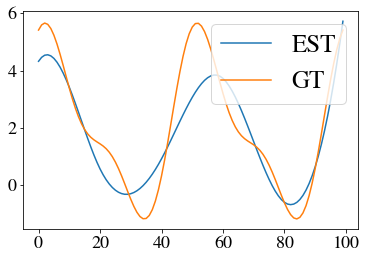

In [40]:
est_beta = res.basis_mat @ res.est_Gam
gt_beta = paras.beta_GT[:, res.keep_idxs]
idx = -1
plt.plot(est_beta[:, idx], label="EST")
plt.plot(gt_beta[:, idx], label="GT")
plt.legend()

### Multipe test

In [9]:
def outlier_det(T_vs, ratio_tol=0.05):
    """
    Detects outliers in a given dataset using the interquartile range (IQR) method.

    Parameters:
    - T_vs (array-like): The input dataset.
    - ratio_tol (float, optional): The tolerance ratio for outlier removal. Default is 0.05.

    Returns:
    - kpidx (ndarray): A boolean array indicating whether each data point is an outlier or not.
    """
    Q1, Q3 = np.quantile(T_vs, [0.25, 0.75])
    IQR = Q3 - Q1
    upbd = Q3 + 1.5*IQR
    lowbd = Q1 - 1.5*IQR
    kpidx = np.bitwise_and(T_vs>=lowbd, T_vs<=upbd)
    
    if np.mean(kpidx)+ ratio_tol < 1:
        out_part = np.stack([T_vs - upbd, lowbd - T_vs]).T.max(axis=1);
        kpidx = np.ones(len(T_vs), dtype=bool)
        kpidx[np.argsort(-out_part)[:int(len(T_vs)*ratio_tol)]] = False
    return kpidx

In [13]:
seed = 12
N = 12
lam = 0.9
paras.beta = 10
def _run_fn1(seed):
    Cmat = paras.Cmats[0]
    res = _run_fn(seed=seed, lam=lam, N=N, paras=paras, is_cv=False, verbose=1)
    res.hypo_test(Cmat, is_simpler=True)
    test_res = edict()
    test_res.update(res.hypo_test_res)
    test_res.L0 = torch.sum(torch.linalg.norm(res.est_Gam, axis=0)!=0).item()
    test_res.AIC = res.GIC_fn("AIC")
    test_res.BIC = res.GIC_fn("BIC")
    test_res.GCV = res.GCV_fn()
    test_res.est_sigma2 = res.hypo_utils.est_sigma2
    test_res.iters = res.conv_iter
    return test_res
    
num_rep = 100
with Parallel(n_jobs=20) as parallel:
    test_ress = parallel(delayed(_run_fn1)(seed) for seed in tqdm(range(num_rep), total=num_rep))
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.60it/s]


The size is 0.040 and the mean of Tv is 10.226 and thoeretically it is 12. L0 is 7.52.
AIC is 0.82. BIC is 2.37. GCV is 3.68. 
est_sigma2 is 0.88514. 


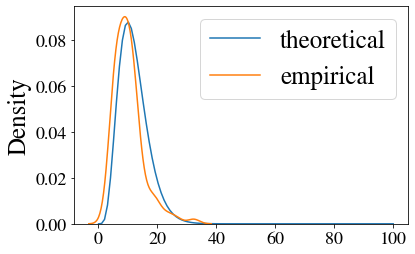

In [16]:
pvals = np.array([res.pval for res in test_ress])
T_vs = np.array([res.T_v for res in test_ress]);
L0s = np.array([res.L0 for res in test_ress]);
AICs = np.array([res.AIC for res in test_ress]);
BICs = np.array([res.BIC for res in test_ress]);
GCVs = np.array([res.GCV for res in test_ress]);
est_sigma2s = np.array([res.est_sigma2 for res in test_ress]);
chi_df = paras.Cmats[0].shape[0]*N
kpidx = outlier_det(T_vs, 0.00)
print(
    f"The size is {np.mean(pvals[kpidx]<0.05):.3f} and "
    f"the mean of Tv is {np.mean(T_vs[kpidx]):.3f} and thoeretically it is {chi_df:.0f}. "
    f"L0 is {np.mean(L0s[kpidx]):.2f}."
     )
print(
    f"AIC is {np.mean(AICs[kpidx]):.2f}. "
    f"BIC is {np.mean(BICs[kpidx]):.2f}. "
    f"GCV is {np.mean(GCVs[kpidx]):.2f}. \n"
    f"est_sigma2 is {np.mean(est_sigma2s[kpidx]):.5f}. "
     )

chi_df = paras.Cmats[0].shape[0]*N
xs = np.linspace(0.1, 100, 100)
theo_curvs_log = chi2.logpdf(xs, chi_df);
plt.plot(xs, np.exp(theo_curvs_log) , label="theoretical")
sns.kdeplot(T_vs[kpidx], label="empirical")
plt.legend()